In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## 1. Descriptive tasks

In [2]:
# Load the dataset
file_path = 'Heart Attack.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure of the dataset
data.head()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64,Male,66,160,83,160.0,1.80,0.012,negative
1,21,Male,94,98,46,296.0,6.75,1.060,positive
2,55,Male,64,160,77,270.0,1.99,0.003,negative
3,64,Male,70,120,55,270.0,13.87,0.122,positive
4,55,Male,64,112,65,300.0,1.08,0.003,negative


#### a. Write a description on the dataset using your own words

The dataset appears to contain medical data focused on predicting heart attack outcomes. Here is a breakdown of the available features:

- `age`: The age of the patient.
- `gender`: The gender of the patient (Male/Female).
- `impluse`: Heart rate (impulse).
- `pressurehight`: Systolic blood pressure.
- `pressurelow`: Diastolic blood pressure.
- `glucose`: Blood glucose level.
- `kcm`: Levels of potassium (K).
- `troponin`: Levels of troponin, a protein indicative of heart damage.
- `class`: Target variable indicating the presence or absence of a heart attack (positive/negative).

#### b. Numerical Summaries

In [3]:
# Extract numerical summaries
numerical_summary = data.describe()
numerical_summary

,age,impluse,pressurehight,pressurelow,glucose,kcm,troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


#### c. Graphical Summaries

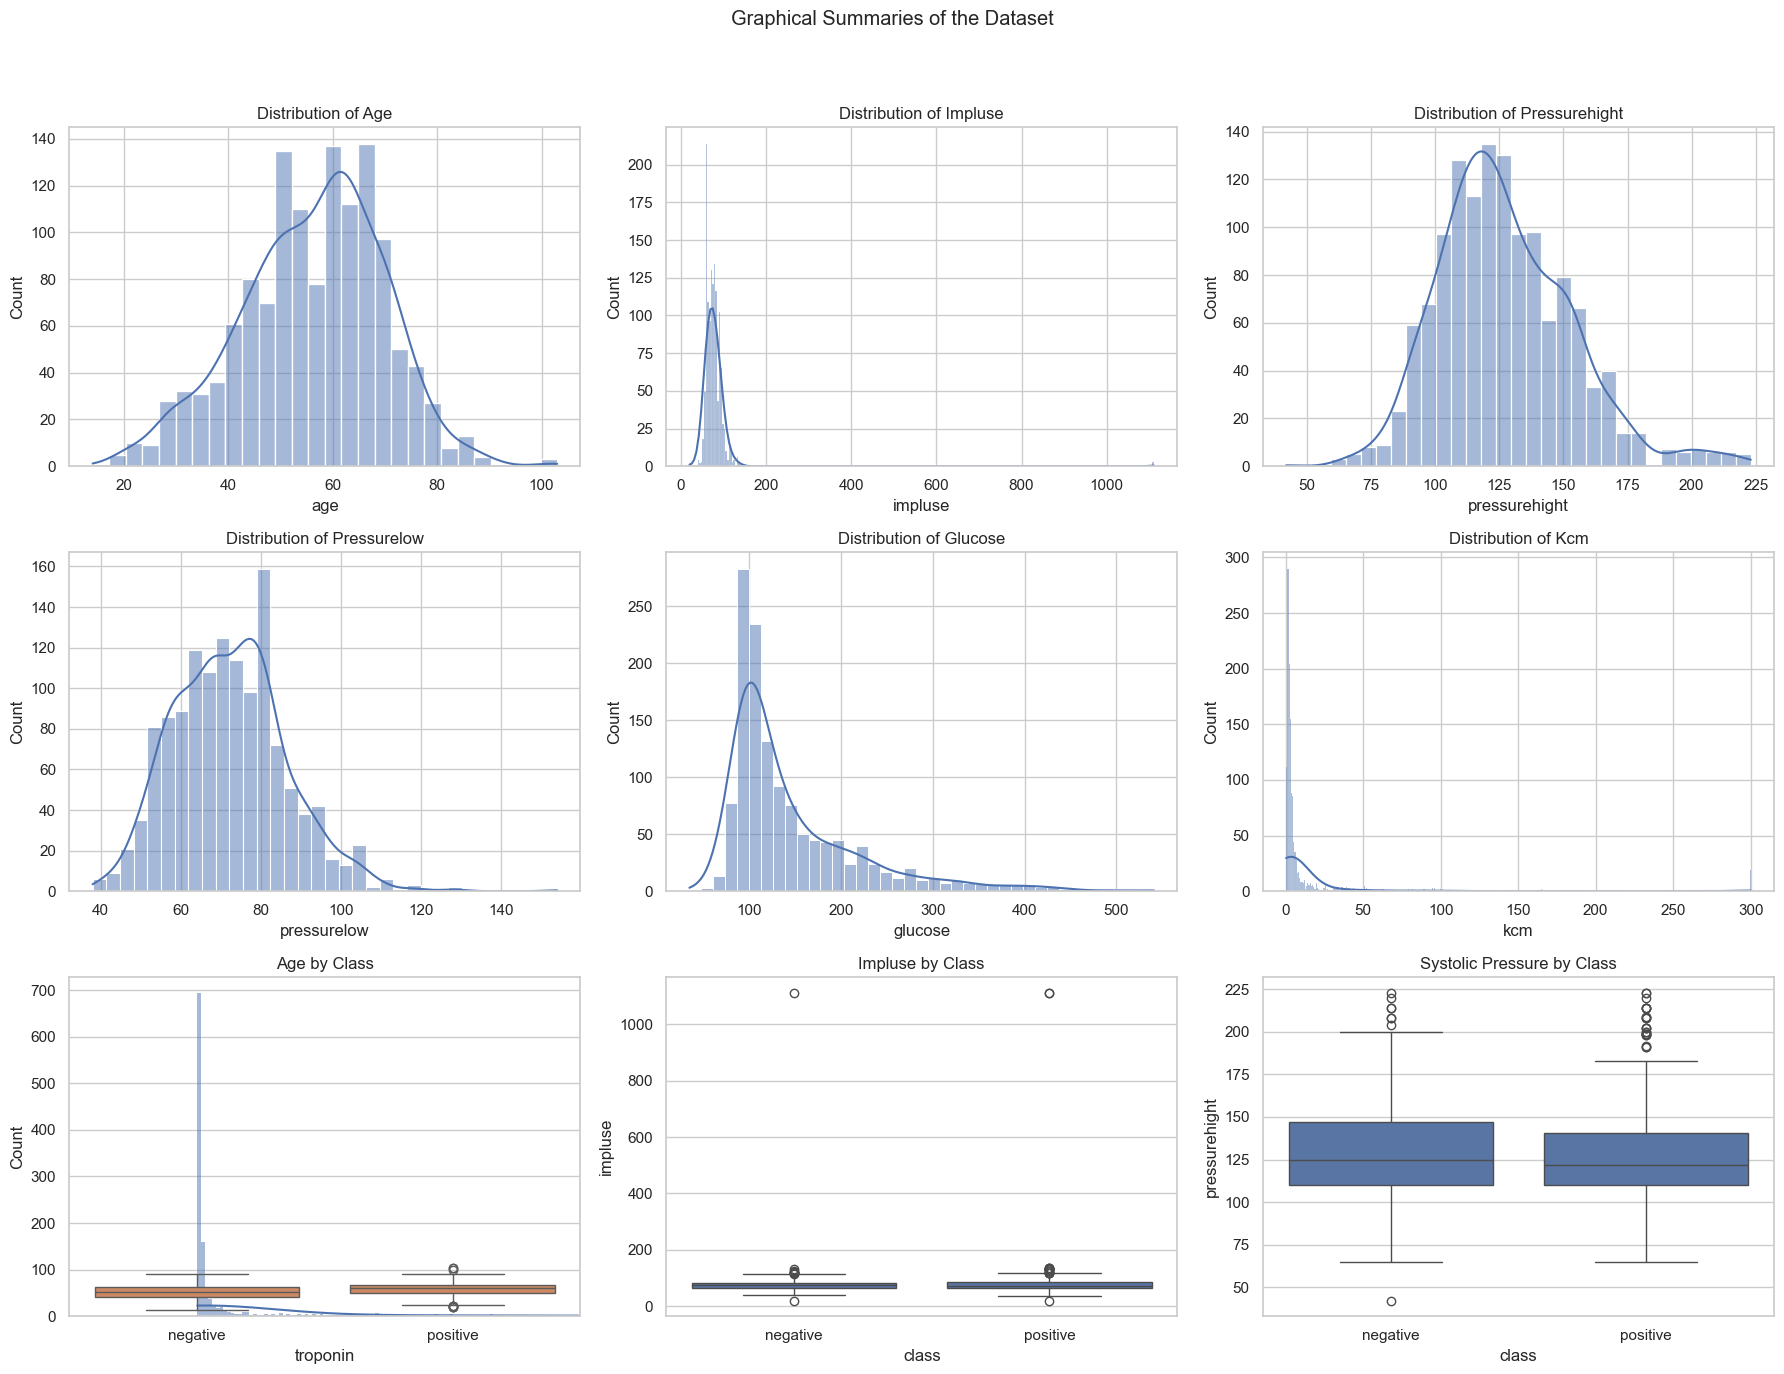

In [4]:
# Plot configuration
sns.set(style='whitegrid')
fig, axs = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle("Graphical Summaries of the Dataset")

# Histogram Plots
columns = ['age', 'impluse', 'pressurehight', 'pressurelow', 'glucose', 'kcm', 'troponin']
for i, col in enumerate(columns):
    sns.histplot(data[col], kde=True, ax=axs[i // 3, i % 3])
    axs[i // 3, i % 3].set_title(f'Distribution of {col.capitalize()}')

# Boxplot for Target Variable
sns.boxplot(x='class', y='age', data=data, ax=axs[2, 0])
axs[2, 0].set_title('Age by Class')

sns.boxplot(x='class', y='impluse', data=data, ax=axs[2, 1])
axs[2, 1].set_title('Impluse by Class')

sns.boxplot(x='class', y='pressurehight', data=data, ax=axs[2, 2])
axs[2, 2].set_title('Systolic Pressure by Class')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

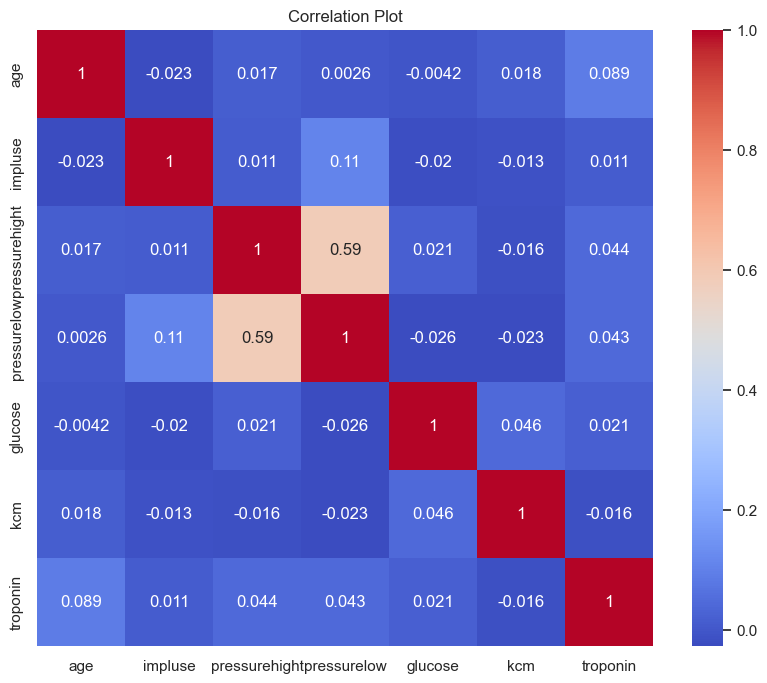

In [5]:
# Correlation plot
plt.figure(figsize=(10, 8))
corr = data[columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Plot")
plt.show()

#### d. Observations

**Numerical Summaries Observations**

- **Age:**
  - The mean age is around 56.19 years.
  - A wide age range from 14 to 103 years suggests a diverse dataset.
  - The standard deviation is relatively high at 13.65, indicating considerable variation.

- **Impluse (Heart Rate):**
  - Average impluse is 78.34 bpm, which is within a normal range.
  - High standard deviation (51.63) and max value (1111 bpm) indicate outliers or erroneous data.

- **Blood Pressure:**
  - Systolic pressure (pressurehight) ranges from 42 to 223 mmHg, with a mean of 127.17 mmHg.
  - Diastolic pressure (pressurelow) ranges from 38 to 154 mmHg, with a mean of 72.27 mmHg.
  - Both measures display significant variation.

- **Glucose:**
  - The mean glucose level is 146.63 mg/dL, suggesting some cases of elevated levels (possibly diabetic).
  - The range extends from 35 to 541 mg/dL, with a standard deviation of 74.92.

- **KCM (Potassium Levels):**
  - Mean level is 15.27, with a maximum of 300, suggesting potential data errors or anomalies.
  - A large standard deviation (46.33) implies high variability.

- **Troponin:**
  - Troponin ranges from 0.001 to 10.3, with a mean of 0.36.
  - High variation with a standard deviation of 1.15.

**Graphical Summaries Observations**

- **Histograms:**
  - All histograms, except for `troponin`, show a right-skewed distribution.
  - Outliers are evident in features like `impluse`, `pressurehight`, `pressurelow`, `glucose`, and `kcm`.

- **Box Plots (by Class):**
  - Patients with positive heart attack class tend to have higher `impluse`, `pressurehight`, and `pressurelow`.

- **Correlation Plot:**
  - Positive correlation exists between `pressurehight` and `pressurelow`.
  - `Troponin` shows a moderate positive correlation with both `pressurehight` and `pressurelow`.
  - `Glucose` does not correlate strongly with other features.

## 2. Preprocessing tasks

In [6]:
# Prepare data
X = data.drop(columns=['class', 'gender'])  # Exclude target and categorical columns
y = data['class'].replace({'positive': 1, 'negative': 0})  # Convert target to binary

#### a. Normalize the feature variables using z-scores

In [7]:
def z_score_normalize(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

#### b. Normalize the feature variables using min-max

In [8]:
def min_max_normalize(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

In [9]:
# Classification models
def build_models():
    return {
        'Decision Tree': DecisionTreeClassifier(random_state=0),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Naive Bayes': GaussianNB(),
        'SVM (Poly)': SVC(kernel='poly', random_state=0),
        'SVM (RBF)': SVC(kernel='rbf', random_state=0),
        'Neural Network': MLPClassifier(random_state=0)
    }

In [10]:
# Classification function
def classify(X_train, X_test, y_train, y_test):
    # Initialize an empty dictionary to store the results for each model
    results = {}

    # Get the dictionary of models (name-model pairs)
    models = build_models()

    # Loop through each model in the dictionary
    for name, model in models.items():
        # Train the model using the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Compute the accuracy score and store it in the results dictionary
        results[name] = accuracy_score(y_test, y_pred)

    # Return the dictionary containing the accuracy scores for all models
    return results

In [11]:
# Data Splits
def split_data(random_state):
    return train_test_split(X, y, test_size=0.3, random_state=random_state)

In [12]:
# Experiment
def run_experiment(normalization_fn, random_states):
    # Initialize an empty dictionary to store the results for each random state
    results = {}

    # Loop through each random state provided in the list
    for random_state in random_states:
        # Split the data into training and testing sets based on the current random state
        X_train, X_test, y_train, y_test = split_data(random_state)

        # Apply the normalization function to the training data
        X_train_norm = normalization_fn(X_train)

        # Apply the normalization function to the testing data
        X_test_norm = normalization_fn(X_test)

        # Classify the normalized training and testing data and store the results in the dictionary
        results[random_state] = classify(X_train_norm, X_test_norm, y_train, y_test)

    # Return the dictionary containing results for each random state
    return results

In [13]:
# Averaging results
def average_results(results):
    model_names = list(next(iter(results.values())).keys())
    averaged = {model: np.mean([res[model] for res in results.values()]) for model in model_names}
    return averaged

In [14]:
# Consolidated Table Function
def create_results_table(normalization_results):
    # Extract the list of model names from the results of the z-score normalization
    model_names = list(next(iter(normalization_results['z_score'].values())).keys())
    
    # Define the column labels for the table
    column_labels = [
        'Z-Score Split 1', 'Z-Score Split 2', 'Z-Score Split 3', 'Z-Score Avg',
        'Min-Max Split 1', 'Min-Max Split 2', 'Min-Max Split 3', 'Min-Max Avg'
    ]
    
    # Initialize a dictionary with model names as keys and empty lists as values
    table = {model: [] for model in model_names}

    # Loop through each model name
    for model in model_names:
        # Extract results for z-score normalization
        z_scores = normalization_results['z_score']
        # Extract results for min-max normalization
        min_max = normalization_results['min_max']

        # Retrieve the accuracy scores for each split using z-score normalization
        z_split1 = z_scores[1][model]
        z_split2 = z_scores[20][model]
        z_split3 = z_scores[40][model]
        # Calculate the average accuracy across the splits for z-score normalization
        z_avg = np.mean([z_split1, z_split2, z_split3])

        # Retrieve the accuracy scores for each split using min-max normalization
        mm_split1 = min_max[1][model]
        mm_split2 = min_max[20][model]
        mm_split3 = min_max[40][model]
        # Calculate the average accuracy across the splits for min-max normalization
        mm_avg = np.mean([mm_split1, mm_split2, mm_split3])

        # Populate the table with all split accuracies and their averages
        table[model] = [z_split1, z_split2, z_split3, z_avg,
                        mm_split1, mm_split2, mm_split3, mm_avg]

    # Convert the table dictionary to a DataFrame and transpose it to get models as rows
    df_table = pd.DataFrame(table, index=column_labels).T

    # Return the resulting DataFrame
    return df_table

In [15]:
# Perform the experiments
random_states = [1, 20, 40]
z_score_results = run_experiment(z_score_normalize, random_states)
min_max_results = run_experiment(min_max_normalize, random_states)

In [16]:
# Average the results
normalization_results = {
    'z_score': z_score_results,
    'min_max': min_max_results
}

In [17]:
results_table = create_results_table(normalization_results)
results_table

,Z-Score Split 1,Z-Score Split 2,Z-Score Split 3,Z-Score Avg,Min-Max Split 1,Min-Max Split 2,Min-Max Split 3,Min-Max Avg
Decision Tree,0.797980,0.633838,0.580808,0.670875,0.929293,0.982323,0.967172,0.959596
KNN,0.659091,0.621212,0.659091,0.646465,0.631313,0.631313,0.631313,0.631313
Naive Bayes,0.676768,0.674242,0.648990,0.666667,0.641414,0.664141,0.666667,0.657407
SVM (Poly),0.641414,0.681818,0.613636,0.645623,0.757576,0.727273,0.739899,0.741582
SVM (RBF),0.734848,0.727273,0.712121,0.724747,0.686869,0.699495,0.689394,0.691919
Neural Network,0.792929,0.785354,0.765152,0.781145,0.737374,0.732323,0.744949,0.738215


### Observations:
1. **Normalization Techniques:**
   - **Z-Score Normalization:**
     - Decision Tree: Highest accuracy on split 1, but shows a slight decline in splits 2 and 3.
     - Neural Network and SVM (RBF) provide relatively consistent and high accuracies across all splits.
   - **Min-Max Normalization:**
     - Decision Tree: Highest average accuracy among all models using Min-Max normalization.
     - Neural Network and SVM (RBF) models show stable performance across all splits.

2. **Data Splits:**
   - Split 1 generally produces the highest accuracies.
   - Accuracy decreases slightly in splits 2 and 3 for most models.

3. **Regression Techniques:**
   - **Decision Tree:** Performs best with Min-Max normalization.
   - **KNN (K=5):** Consistent but slightly lower accuracies compared to Decision Tree and Neural Network models.
   - **Naive Bayes:** Lower accuracy due to its simplistic assumptions.
   - **SVM (Poly and RBF):** Perform consistently well, especially with Z-Score normalization.
   - **Neural Network:** Stable accuracy across different splits and normalization techniques. 

Overall, normalization techniques and data splits influence classifier performance, with Decision Trees and Neural Networks emerging as the top performers.